<Figure size 432x288 with 0 Axes>

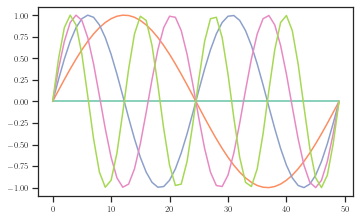

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os 

PT_PER_INCH = 72.27
GOLDEN_RATIO = (5**.5 - 1) / 2

TEXTWIDTH_PT = 408.0 # \showthe\textwidth
TEXTWIDTH_IN = TEXTWIDTH_PT/PT_PER_INCH

TEXTHEIGHT_PT = 665.2019 # \showthe\textheight
TEXTHEIGHT_IN = TEXTHEIGHT_PT/PT_PER_INCH

REPORT_PATH = "report"
FIGURES_PATH = os.path.join("report", "figures")
STYLE_PATH = os.path.join("report", "thesis.mplstyle")

SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH

RC_PARAMS = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "legend.edgecolor": "inherit",
    "legend.fancybox": False,
    "legend.framealpha": 1.0,
    "figure.titlesize": 12,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

def figsize(fraction=1.0, width=TEXTWIDTH_IN, ratio=GOLDEN_RATIO, subplots=(1, 1)):
    fig_width = fraction*width
    fig_height = fig_width*ratio*(subplots[0]/subplots[1])
    return fig_width, fig_height

def figpath(name, format="pgf"):
    return os.path.join(FIGURES_PATH, f"{name}.{format}")

#plt.style.use(["default", ])

sns.set_theme(style='ticks', palette='Set2', rc=RC_PARAMS)
sns.despine()

plt.figure(figsize=figsize())
for i in range(5):
    plt.plot(np.sin(np.linspace(0, i*2*np.pi)))
plt.show()

In [68]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

## Environments

### Overviews

In [2]:
import gym
import gym_search

def plot_environment(env_id, seed=0, position=None, layout=[[0]], width=TEXTWIDTH_IN):
    layout = np.array(layout)
    flattened = layout.flatten()
    unique = set(flattened)
    count = len(unique)
    ratio = layout.shape[0]/layout.shape[1]

    fig, axs = plt.subplot_mosaic(layout, figsize=figsize(ratio=ratio, width=width))
    env = gym.make(env_id)

    for i in range(count):
        env.reset(seed=seed if i == 0 else None)
        env.plot(axs[i], overlay=(i == 0), position=position)

    fig.tight_layout()

    return fig

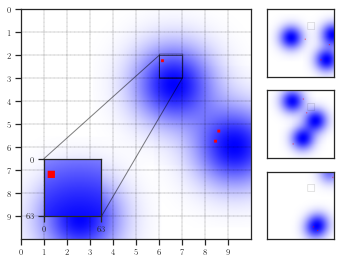

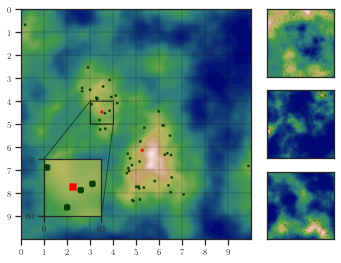

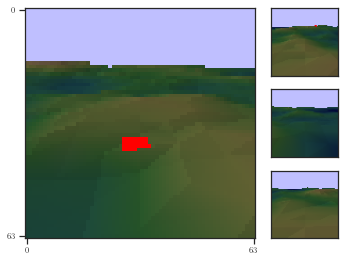

In [19]:
REPORT_LAYOUT = [
    [0, 0, 0, 1],
    [0, 0, 0, 2],
    [0, 0, 0, 3],
]

plot_environment("Gaussian-v0", seed=1, layout=REPORT_LAYOUT, position=np.array([2, 6])).savefig(figpath("gaussian", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=6, layout=REPORT_LAYOUT, position=np.array([4, 3])).savefig(figpath("terrain", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=REPORT_LAYOUT, position=np.array([2, 0])).savefig(figpath("camera", format="pgf"), dpi=300, bbox_inches='tight')

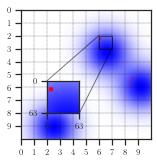

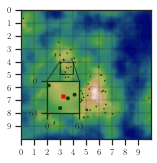

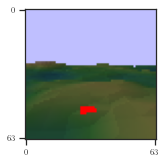

In [3]:
SLIDES_LAYOUT = [[0]]

plot_environment("Gaussian-v0", seed=1, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([2, 6])).savefig(figpath("gaussian", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=6, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([4, 3])).savefig(figpath("terrain", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([1, 0])).savefig(figpath("camera", format="pdf"), dpi=300, bbox_inches='tight')

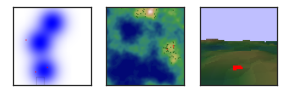

In [5]:
import gym
import gym_search

SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH
LAYOUT = [[0, 1, 2]]
ENV_IDS = ["Gaussian-v0", "Terrain-v0", "Camera-v0"]
SEEDS = [0, 0, 0]
POSITIONS = [np.array([9, 3]), np.array([9, 12]), np.array([1, 0])]
RATIO = 1.0/len(LAYOUT)

fig, axs = plt.subplot_mosaic(LAYOUT, figsize=figsize(ratio=RATIO, width=SLIDES_TEXTWIDTH_IN))
envs = [gym.make(env_id) for env_id in ENV_IDS]

for i in range(len(ENV_IDS)):
    ax, env, seed, position = axs[i], envs[i], SEEDS[i], POSITIONS[i]
    env.reset(seed=seed)
    env.plot(ax, overlay=False, inset=False, position=position)

fig.savefig(figpath("environments", format="pdf"), dpi=300, bbox_inches='tight')

## Experiments

In [44]:
import csv

# https://github.com/openai/train-procgen/blob/master/train_procgen

def ema(data_in, smoothing=0):
    data_out = np.zeros_like(data_in)
    curr = np.nan

    for i in range(len(data_in)):
        x = data_in[i]
        if np.isnan(curr):
            curr = x
        else:
            curr = (1 - smoothing) * x + smoothing * curr

        data_out[i] = curr

    return data_out


def plot_data_mean_std(ax, data_y, data_x=None, x_scale=1, smoothing=0, first_valid=0, label=None):
    data_y = data_y[:,first_valid:]
    nx, num_datapoint = np.shape(data_y)

    if smoothing > 0:
        for i in range(nx):
            data_y[i,...] = ema(data_y[i,...], smoothing)

    if data_x is None:
        data_x = (np.array(range(num_datapoint)) + first_valid) * x_scale

    data_mean = np.mean(data_y, axis=0)
    data_std = np.std(data_y, axis=0, ddof=1)

    line, = ax.plot(data_x, data_mean, label=label, linestyle='solid', alpha=1, rasterized=True)
    ax.fill_between(data_x, data_mean - data_std, data_mean + data_std, color=line.get_color(), alpha=.25, linewidth=0.0, rasterized=True)
    
    return line


def read_csv(filename, key_name):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        key_index = -1

        values = []

        for line_num, row in enumerate(csv_reader):
            row = [x.lower() for x in row]

            if line_num == 0:
                idxs = [i for i, val in enumerate(row) if val == key_name]
                key_index = idxs[0]
            else:
                values.append(row[key_index])

    return np.array(values, dtype=np.float32)

def plot_values(ax, all_values, max_x=0, label=None, **kwargs):
    if max_x > 0:
        all_values = all_values[...,:max_x]

    return plot_data_mean_std(ax, all_values, label=label, **kwargs)

### Curves

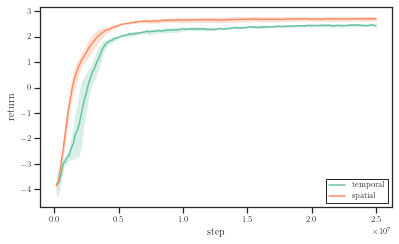

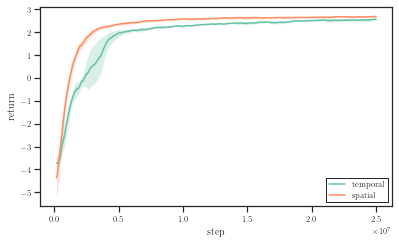

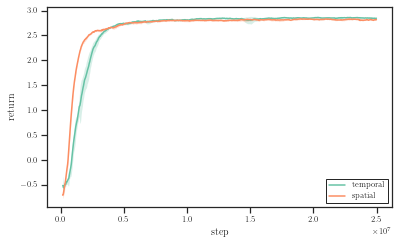

In [4]:
timesteps = int(25e6)
environments = ["gaussian", "terrain", "camera"]
seeds = [0, 1, 2]
field = "return"

for i, environment in enumerate(environments):
    fig, ax = plt.subplots(figsize=figsize(width=TEXTWIDTH_IN))

    data = {
        "temporal": [f"results/{environment}/lstm/{seed}/train.csv" for seed in seeds],
        "spatial": [f"results/{environment}/map/{seed}/train.csv" for seed in seeds],
    }

    for label, csv_files in data.items():
        raw_data = np.array([read_csv(f, field) for f in csv_files])
        plot_values(ax, raw_data, label=label, smoothing=0.95, first_valid=10, x_scale=timesteps/raw_data.shape[1])

    ax.set_xlabel("step")
    ax.set_ylabel(field)
    ax.legend()

    fig.tight_layout()
    fig.savefig(figpath(f"learning-{environment}"), bbox_inches="tight", dpi=300)

### Quality

In [1]:
import pandas as pd
import numpy as np

ENVIRONMENTS = ["gaussian"] #, "terrain", "camera"]
METRICS = ["spl", "success", "length"]
AGENTS = {
    "random": "random",
    "greedy": "greedy",
    "exhaustive": "exhaustive",
    "handcrafted": "handcrafted",
    "human": "human",
    "lstm": "temporal",
    "map": "spatial",
}

for env in ENVIRONMENTS:

    print(env)

    for agent, name in AGENTS.items():

        df = pd.read_csv(f"results/{env}/{agent}/test.csv", index_col="id")
        metrics = []

        for key in METRICS:
            metrics.append((np.mean(df[key]), np.std(df[key], ddof=1)))
    
        print(f"{name} & " + " & ".join(fr"${mean:.2f} \pm {std:.2f}$" for mean, std in metrics) + r"\\")

gaussian
random & $0.06 \pm 0.01$ & $0.92 \pm 0.06$ & $369.07 \pm 24.93$\\
greedy & $0.17 \pm 0.00$ & $1.00 \pm 0.00$ & $147.12 \pm 2.38$\\
exhaustive & $0.21 \pm 0.00$ & $1.00 \pm 0.00$ & $83.37 \pm 2.88$\\
handcrafted & $0.33 \pm 0.00$ & $1.00 \pm 0.00$ & $65.20 \pm 1.41$\\
human & $0.23 \pm 0.03$ & $1.00 \pm 0.00$ & $80.97 \pm 13.49$\\
temporal & $0.24 \pm 0.03$ & $0.99 \pm 0.01$ & $101.25 \pm 13.32$\\
spatial & $0.29 \pm 0.02$ & $0.99 \pm 0.01$ & $72.16 \pm 5.97$\\


### Shape

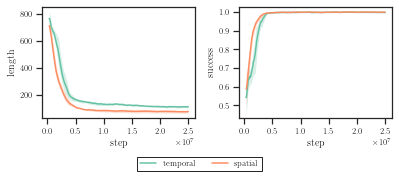

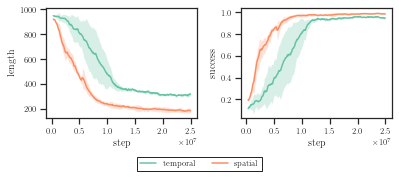

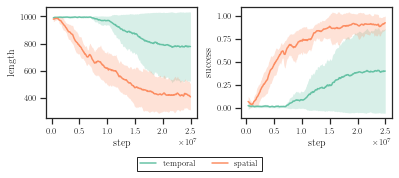

In [47]:
timesteps = int(25e6)
shapes = [10, 15, 20]
fields = ["length", "success"]
seeds = [0, 1, 2, 3]

for i, shape in enumerate(shapes):
    fig, axs = plt.subplots(1, 2, figsize=figsize(width=TEXTWIDTH_IN, ratio=0.4))

    data = {
        "temporal": [f"results/shape/lstm/{shape}/{seed}/train.csv" for seed in seeds],
        "spatial": [f"results/shape/map/{shape}/{seed}/train.csv" for seed in seeds],
    }

    for ax, field in zip(axs, fields):
        for label, csv_files in data.items():
            raw_data = np.array([read_csv(f, field) for f in csv_files])
            plot_values(ax, raw_data, label=label, smoothing=0.95, first_valid=20, x_scale=timesteps/raw_data.shape[1])

        ax.set_xlabel("step")
        ax.set_ylabel(field)

    if i == len(shapes) - 1:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), ncol=len(shapes), loc="lower center", bbox_to_anchor=(0.5, -0.1))

    fig.tight_layout()
    fig.savefig(figpath(f"shape-{shape}", format="pgf"), bbox_inches="tight", dpi=300)


### Samples

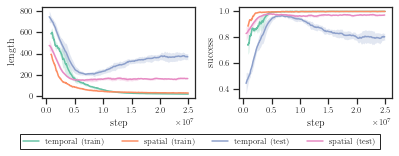

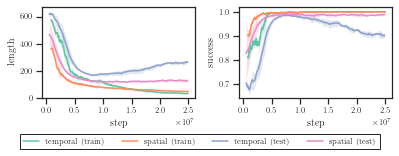

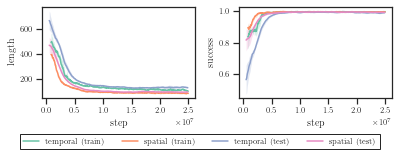

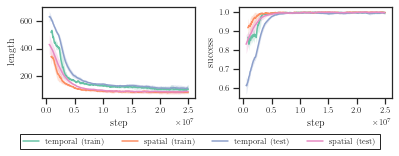

In [48]:
timesteps = int(25e6)
fields = ["length", "success"]
seeds = range(3)
samples = [500, 1000, 5000, 10000]


for i, sample in enumerate(samples):

    fig, axs = plt.subplots(1, 2, figsize=figsize(width=TEXTWIDTH_IN, ratio=0.35))

    train_data = {
        "temporal (train)": [f"results/sample/lstm/{sample}/{seed}/train.csv" for seed in seeds],
        "spatial (train)": [f"results/sample/map/{sample}/{seed}/train.csv" for seed in seeds],
    }

    test_data = {
        "temporal (test)": [f"results/sample/lstm/{sample}/{seed}/test.csv" for seed in seeds],
        "spatial (test)": [f"results/sample/map/{sample}/{seed}/test.csv" for seed in seeds],
    }

    for ax, field in zip(axs, fields):

        for label, csv_files in train_data.items():
            raw_data = np.array([read_csv(f, field) for f in csv_files])
            plot_values(ax, raw_data, label=label, smoothing=0.9, first_valid=50, x_scale=timesteps/raw_data.shape[1])


        for label, csv_files in test_data.items():
            raw_data = np.array([read_csv(f, field) for f in csv_files])
            plot_values(ax, raw_data, label=label, smoothing=0.9, first_valid=5, x_scale=timesteps/raw_data.shape[1])

        ax.set_xlabel("step")
        ax.set_ylabel(field)

    if i == len(samples) - 1:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), ncol=len(samples), loc="lower center", bbox_to_anchor=(0.5, -0.1))

    fig.tight_layout()
    fig.savefig(figpath(f"sample-{sample}", format="pgf"), bbox_inches="tight", dpi=300)


## Extra

### Paths

In [2]:
import gym
import gym_search
import rl
import torch as th
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MaxNLocator

from test import play


def plot_path(ax, env_info, xlabel="$p_{t,1}$", ylabel="$p_{t,0}$", tlabel="step $t$", colorbar=True):    
    info = env_info
    path = np.array(info["path"])    

    green = sns.color_palette()[0]
    red = sns.color_palette()[1]
    blue = sns.color_palette()[2]

    cmap = sns.dark_palette(blue, reverse=True, as_cmap=True)
    c = cmap(np.linspace(0.0, 1.0, len(path)))

    for i, (p1, p2) in enumerate(zip(path, path[1:])):
        x = [p1[1], p2[1]]
        y = [p1[0], p2[0]]
        ax.plot(x, y, color=c[i], linewidth=2, alpha=1)

    targets = np.array(info["targets"])
    ax.scatter(targets[:,1],targets[:,0], color=red, marker="o", label="target", zorder=100)

    if 0 in info["actions"]:
        triggers = np.array([p for p, a in zip(info["path"], info["actions"]) if a == 0])
        ax.scatter(triggers[:,1], triggers[:,0], color=green, marker="x", label="indicate", zorder=100)
    else:
        ax.scatter([], [], color=green, marker="x", label="indicate", zorder=100)

    #ax.set_ylim(-1, env.shape[0])
    #ax.set_ylim(-1, env.shape[1])
    #ax.set_yticks(range(env.shape[0]))
    #ax.set_xticks(range(env.shape[1]))
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.invert_yaxis()

    ax.legend()

    if colorbar:
        fig = ax.get_figure()
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes('right', size='5%', pad=0.05)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(path)))
        #fig.colorbar(sm, cax=cax, orientation="vertical", label=tlabel)
        fig.colorbar(sm, label=tlabel)


def play_and_plot_path(env_id, agent=None, model=None, device=None, seed=None):
    assert agent is not None or model is not None
    assert model is None or device is not None

    fig, ax = plt.subplots(figsize=figsize(width=TEXTWIDTH_IN*0.75, ratio=0.9))

    env = gym.make(env_id)

    info, = play(1, env, agent=agent, model=model, device=device, hidden=True, seed=seed)
    plot_path(ax, info)

    fig.tight_layout()

    return fig

/home/oslund/Thesis/rl/algorithms.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import init_builtin
/home/oslund/Thesis/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


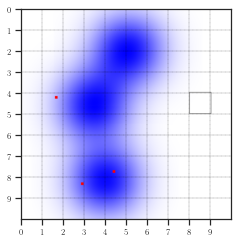

In [27]:
import gym
import gym_search

SEED = 0
ENV_ID = "Gaussian-v0"
AGENTS = ["random", "greedy", "exhaustive", "handcrafted"]
MODELS = [("lstm", "models/gaussian/lstm/0.pt"), ("map", "models/gaussian/map/0.pt")]

env = gym.make(ENV_ID)
env.reset(seed=SEED)

fig, ax = plt.subplots(figsize=figsize())
env.plot(ax, inset=False)

fig.tight_layout()
#fig.savefig(figpath(f"path-scene", format="pgf"), dpi=300)
fig.savefig(figpath(f"path-scene", format="pdf"), dpi=300, bbox_inches='tight')

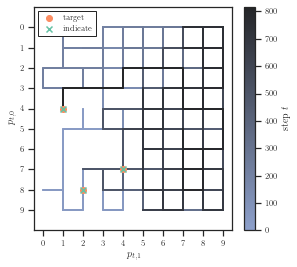

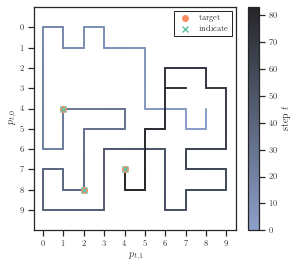

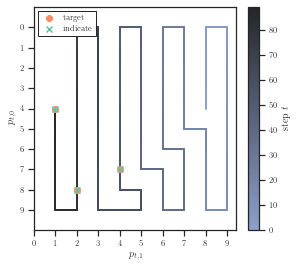

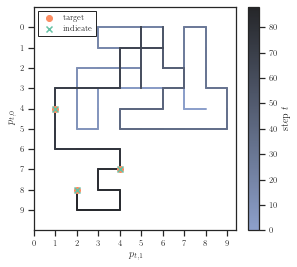

In [36]:
for agent in AGENTS:
    fig = play_and_plot_path(ENV_ID, agent=agent, seed=SEED)
    fig.tight_layout()
    #fig.savefig(figpath(f"path-{agent}", format="pgf"), dpi=300)
    fig.savefig(figpath(f"path-{agent}", format="pdf"), dpi=300, bbox_inches='tight')

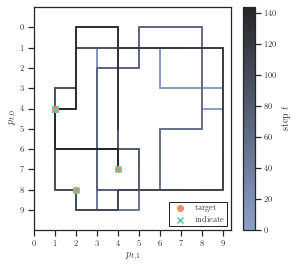

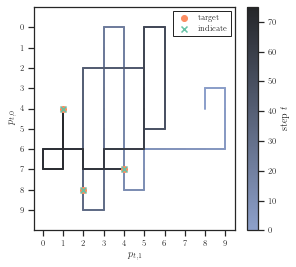

In [40]:
device = th.device("cpu")
for name, file in MODELS:
    model = th.load(file, map_location=device)
    fig = play_and_plot_path(ENV_ID, model=model, device=device, seed=SEED)
    #fig.savefig(figpath(f"path-{name}", format="pgf"), dpi=300)
    fig.savefig(figpath(f"path-{name}", format="pdf"), dpi=300)

### Tensorboard

In [108]:
from glob import glob
from scipy import stats
from functools import lru_cache
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator, STORE_EVERYTHING_SIZE_GUIDANCE


def load_scalars(events, tag):
    event_acc = EventAccumulator(events, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
    event_acc.Reload()
    scalars = event_acc.Scalars(tag)
    df = pd.DataFrame(scalars)
    return df


def smooth(scalars, weight):
    last = scalars[0]
    smoothed = []

    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

### Memory Visualization

#### Spatial Memory (Map)

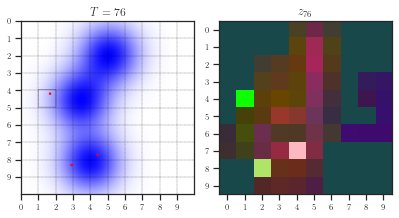

In [42]:
import torch as th
import numpy as np

import rl
import gym
import gym_search

from sklearn.decomposition import PCA


fig, (ax_env, ax_map) = plt.subplots(1, 2, figsize=figsize())

seed = 0
env = gym.make("Gaussian-v0")
device = th.device("cpu")
model = th.load("models/gaussian/map/0.pt", map_location=device)

obs = env.reset(seed=seed)
done = False
state = model.initial(1)

while not done:
    with th.no_grad():
        obs = {key: th.tensor(o).float().unsqueeze(0).to(device) for key, o in obs.items()}
        act, state = model.predict(obs, state, done=th.tensor(done).float().unsqueeze(0).to(device), deterministic=False)

    obs, rew, done, info = env.step(act)

map = state[0].squeeze().cpu()

def map_img(map):
    pca = PCA(n_components=3)

    img = pca.fit_transform(map.flatten(1).transpose(0, 1)).reshape(*map.shape[1:], 3)
    img -= img.min()
    img /= img.max()

    return img

env.plot(ax_env, inset=False)
ax_env.set_title(fr"$T = {env.num_steps}$")

ax_map.imshow(map_img(map))
ax_map.set_xticks(range(env.shape[0]))
ax_map.set_yticks(range(env.shape[1]))
ax_map.set_title(fr"$z_{{{env.num_steps}}}$")

fig.tight_layout()
#fig.savefig(figpath("memory-map", format="pgf"), dpi=300, bbox_inches='tight')
fig.savefig(figpath("memory-map", format="pdf"), dpi=300, bbox_inches='tight')

#### Temporal Memory (LSTM)

/usr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


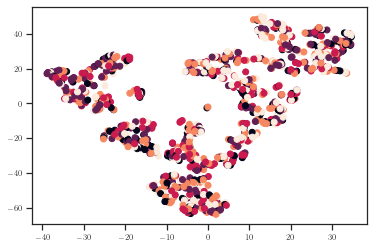

In [14]:
import torch as th
import numpy as np

import rl
import gym
import gym_search

from sklearn.manifold import TSNE

seed = 0
env = gym.make("Gaussian-v0")
device = th.device("cpu")
model = th.load("models/gaussian/lstm/0.pt").to(device)

obs = env.reset(seed=seed)
act = None
done = False
state = [s.to(device) for s in model.initial(1)]

history = []

while not done:
    history.append({"o": obs, "h": [s.detach().cpu().squeeze().numpy() for s in state], "a": act})

    with th.no_grad():
        obs = {key: th.tensor(o).float().unsqueeze(0).to(device) for key, o in obs.items()}
        act, state = model.predict(obs, state, done=th.tensor(done).float().unsqueeze(0).to(device))

    obs, rew, done, info = env.step(act)

x, y = zip(*TSNE(n_components=2).fit_transform([h["h"][0] for h in history]))
c = [h["a"] for h in history]

plt.scatter(x, y, c=c)

### Videos

In [150]:
import os
import rl
import gym
import gym_search
import torch as th
import numpy as np
import imageio
import matplotlib.pyplot as plt

from tqdm import tqdm

env_id = "Terrain-v0"
env_path = "terrain"
agent_id = "map"
env_name = "Terrain Environment"
agent_name = "Spatial Memory"

#camera_seeds = [1, 500, 1000] # 11 is a difficult one

seed = 2
name = seed

def render_frame(obs, info):
    img = obs["image"]
    pos = obs["position"]
    act = None if not info["actions"] else info["actions"][-1]

    fig, (obs_ax, path_ax, text_ax) = plt.subplots(ncols=3, figsize=(8, 4.5), dpi=300, gridspec_kw={"width_ratios": [1, 1, 0.25]})
    fig.subplots_adjust(wspace=0.25)

    obs_ax.set_title("image observation $x_t$")
    obs_ax.imshow(img)
    
    path_ax.set_title("search path")
    plot_path(path_ax, info, colorbar=False)
    path_ax.set_box_aspect(1.0)
    #path_ax.set_ylim(0, env.shape[0]+1)
    #path_ax.set_xlim(0, env.shape[1]+1)

    action = "NONE" if act is None else ["INDICATE", "UP", "RIGHT", "DOWN", "LEFT"][act]
    text_ax.axis("off")
    text_ax.text(0, 0.6, fr"step $t = {env.num_steps}$")
    text_ax.text(0, 0.5, fr"position $p_t = \left({pos[0]}, {pos[1]} \right)$")
    text_ax.text(0, 0.4, fr"action $a_t = \mathtt{{{action}}}$")

    #fig.tight_layout()
    fig.canvas.draw()

    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)

    return frame

env = gym.make(env_id)
device = th.device("cuda")
model = th.load(f"models/{env_path}/{agent_id}/0.pt")
model.eval()

print(f"recording video {seed}...")

done = False
obs, info = env.reset(seed=seed, return_info=True)
state = [s.to(device) for s in model.initial(1)]

frames = []

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
ax.set_title(agent_name)
ax.xaxis.set_label_position('top')
ax.set_xlabel(f"{env_name}, seed {seed}")
ax.imshow(env.render())

fig.canvas.draw()
frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
frames.append(frame)
plt.close(fig)

pbar = tqdm(total=env.max_steps)

frames.append(render_frame(obs, info))

while not done:
    with th.no_grad():
        obs = {k: th.from_numpy(o.copy()).float().unsqueeze(0).to(device) for k, o in obs.items()}
        act, state = model.predict(obs, state, done=th.tensor(done).float().unsqueeze(0).to(device))

    obs, rew, done, info = env.step(act.item())

    frames.append(render_frame(obs, info))
    pbar.update(1)

pbar.close()

os.makedirs(f"videos/{env_path}/{agent_id}", exist_ok=True)
path = f"videos/{env_path}/{agent_id}/{name}.gif"
print(f"saving video of {len(frames)} frames to {path}")
imageio.mimwrite(path, frames, fps=1)


recording video 2...


  8%|▊         | 75/1000 [00:18<03:45,  4.10it/s]


saving video of 77 frames to videos/terrain/map/2.gif


#### Slides

In [8]:
import gym, gym_search
import cv2 as cv
from gym_search.envs import Action

env = gym.make("Camera-v0")
env.reset(seed=0)
for a in [Action.UP]*3 + [Action.RIGHT]*7: env.step(a)

obs = env.observation()
img = cv.cvtColor(obs["image"], cv.COLOR_BGR2RGB)

cv.imwrite(figpath("observation", format="png"), img)

True